In [2]:
using Lux, Optimisers, Random, Statistics, Zygote
using CairoMakie, MakiePublication
using PyCall, NPZ
using Flux: params
using ColorSchemes
using JLD2

np = pyimport("numpy")

PyObject <module 'numpy' from '/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/__init__.py'>

In [3]:
nk = 100
nz = 20
nc = 2000
ncv = 1000

1000

In [4]:
input = npzread("../files/train_in_neu_sym_" * string(nc) * ".npy")
output = npzread("../files/train_out_neu_sym_" * string(nc) * ".npy")

2000×2000 Matrix{Float64}:
 0.0220244  0.0164992  0.0124894  …  4.93924e14  4.5047e14   4.12514e14
 0.0216899  0.0163657  0.0124768     1.47463e14  1.34852e14  1.23807e14
 0.0276261  0.0211559  0.0162725     4.5601e14   4.16147e14  3.81301e14
 0.0224784  0.0168216  0.0127151     6.58978e14  6.00438e14  5.49351e14
 0.0267201  0.0203312  0.0155554     2.73752e14  2.49572e14  2.28456e14
 0.0207169  0.0155647  0.0118307  …  2.4913e14   2.27796e14  2.09114e14
 0.0244672  0.0185853  0.0142205     2.73022e14  2.49353e14  2.28648e14
 0.0246578  0.0186151  0.0141607     2.15169e14  1.96129e14  1.79507e14
 0.0272198  0.0209475  0.016191      8.70484e13  7.96008e13  7.30777e13
 0.0269611  0.0205829  0.0157949     1.29054e14  1.17763e14  1.07894e14
 0.0212263  0.0159057  0.0120549  …  1.15831e14  1.0578e14   9.69902e13
 0.0220085  0.0165433  0.0125648     8.83174e13  8.06561e13  7.39554e13
 0.0246134  0.0187534  0.0143883     2.21387e14  2.02353e14  1.8569e14
 ⋮                                ⋱   

In [5]:
print(size(input), '\n')
print(size(output), '\n')

(4, 2000)
(2000, 2000)


In [6]:
x = input
y = output'

# standardizzazione del trainig dataset (feature - min(features))/(max(features) - min(features))
min_in = minimum(x, dims=2)
max_in = maximum(x, dims=2)

min_out = minimum(y, dims=2)
max_out = maximum(y, dims=2)

x = (x .- min_in) ./ (max_in .- min_in)
y = (y .- min_out) ./ (max_out .- min_out)

2000×2000 Matrix{Float64}:
 0.231817  0.204098  0.696083  0.269447  …  0.605858  0.475443  0.444414
 0.218078  0.204416  0.694751  0.251087     0.597373  0.45797   0.437055
 0.206325  0.204694  0.693358  0.235382     0.589985  0.443074  0.430718
 0.196092  0.205392  0.692404  0.221609     0.583806  0.430264  0.425575
 0.186952  0.206512  0.691928  0.209207     0.578628  0.419005  0.421416
 0.178597  0.207929  0.691817  0.197798  …  0.574191  0.408876  0.417968
 0.170834  0.209516  0.691944  0.187153     0.570289  0.399597  0.415012
 0.163546  0.211177  0.692211  0.177139     0.566776  0.390987  0.412399
 0.156647  0.212817  0.692455  0.167659     0.563484  0.382887  0.409973
 0.14998   0.214214  0.692065  0.158545     0.559895  0.374925  0.407341
 0.143688  0.215557  0.691726  0.149952  …  0.556554  0.367458  0.404887
 0.13776   0.21683   0.691419  0.141864     0.553434  0.360458  0.402587
 0.132186  0.21802   0.691134  0.13427      0.550518  0.353904  0.400425
 ⋮                      

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/VRavR/src/scenes.jl:220


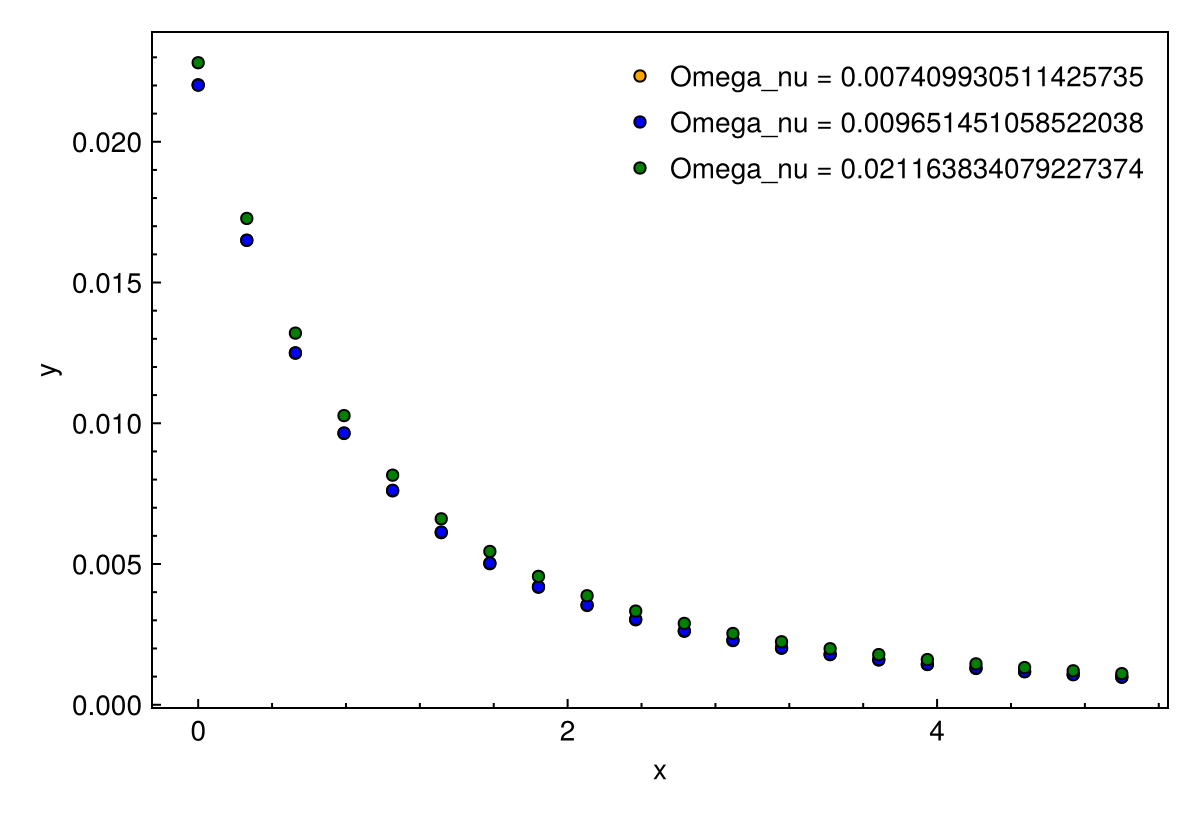

In [7]:

zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h

with_theme(theme_web()) do
    fig = Figure()
    ax = CairoMakie.Axis(fig[1, 1]; xlabel="x", ylabel="y")

    #l = lines!(ax, x[1, :], x -> evalpoly(x, (0, -2, 1)); linewidth=3)
    #s = scatter!(ax, input[1, :], output[:, 1]; markersize=8, color=:orange, strokecolor=:black, strokewidth=1)
    s1 = scatter!(ax, zz, output[1,1:20]; markersize=8, color=:orange, strokecolor=:black, strokewidth=1)
    s2 = scatter!(ax, zz, output[100,1:20]; markersize=8, color=:blue, strokecolor=:black, strokewidth=1)
    s3 = scatter!(ax, zz, output[200,1:20]; markersize=8, color=:green, strokecolor=:black, strokewidth=1)

    axislegend(ax, [s1, s2, s3], ["Omega_nu = " * string(input[1,1]) , "Omega_nu = " * string(input[1,100]), "Omega_nu = " * string(input[1,200])])

    return fig
end

In [8]:
print("x: ", size(x), '\t', "y: ", size(y))

x: (4, 2000)	y: (2000, 2000)

In [9]:
layer_size = 64
in_size = size(x)[1]
out_size = size(y)[1]

nn = Chain(
    Dense(in_size => layer_size, tanh),
    Dense(layer_size => layer_size, tanh),
    Dense(layer_size => layer_size, tanh),
    Dense(layer_size => layer_size, tanh),
    Dense(layer_size => layer_size, tanh),
    Dense(layer_size => out_size)
)


Chain(
    layer_1 = Dense(4 => 64, tanh_fast),  # 320 parameters
    layer_2 = Dense(64 => 64, tanh_fast),  # 4_160 parameters
    layer_3 = Dense(64 => 64, tanh_fast),  # 4_160 parameters
    layer_4 = Dense(64 => 64, tanh_fast),  # 4_160 parameters
    layer_5 = Dense(64 => 64, tanh_fast),  # 4_160 parameters
    layer_6 = Dense(64 => 2000),        # 130_000 parameters
)         # Total: 146_960 parameters,
          #        plus 0 states.

In [10]:
learning_rate = 0.001f0
opt = Adam(learning_rate)

Adam(0.001, (0.9, 0.999), 1.0e-8)

In [11]:
rng = MersenneTwister()
Random.seed!(rng, 12345)

MersenneTwister(12345)

In [16]:
tstate = Lux.Training.TrainState(rng, nn, opt)
tstate.

(layer_1 = (weight = Float32[-0.27694765 0.012844712 0.059683017 0.24004269; -0.06057005 -0.07435051 -0.21305816 0.18546216; … ; -0.017249344 0.18066965 -0.2299257 -0.18365474; 0.09028684 0.27889627 0.08900343 0.061429884], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.004707304 0.012143608 … 0.17360352 -0.16495241; -0.06410121 0.12942693 … 0.14724663 -0.17490081; … ; -0.19028914 0.038308986 … -0.05025386 -0.0007875015; -0.078865625 -0.04673638 … -0.101169325 -0.13739455], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[-0.1454301 0.13358067 … 0.20969066 -0.001176813; -0.119221725 0.057744365 … 0.10176419 0.20196818; … ; -0.11619194 0.19189976 … -0.15597755 0.1390778; 0.13831873 0.048547436 … 0.20047736 -0.020262575], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_4 = (weight = Float32[0.07755605 0.029232124 … 0.13591246 0.19127063; 0.15288174 -0.1658862 … -0.21458282 0.19736159; … ; -0.06773835 0.1808016 … -0.0929862 0.04286969; -0.

In [ ]:
vjp_rule = Lux.Training.AutoZygote()

ADTypes.AutoZygote()

In [ ]:
function loss_function(model, ps, st, data)
    y_pred, st = Lux.apply(model, data[1], ps, st)
    mse_loss = mean(abs2, y_pred .- data[2])
    return mse_loss, st, ()
end

loss_function (generic function with 1 method)

In [ ]:
function main(tstate::Lux.Experimental.TrainState, vjp, data, epochs, i)
    # data = data .|> gpu_device()
    for epoch in 1:epochs
        grads, loss, stats, tstate = Lux.Training.compute_gradients(
            vjp, loss_function, data, tstate)
        println("Epoch: $(i).$(epoch)\t|| Loss: $(loss)")
        tstate = Lux.Training.apply_gradients(tstate, grads)
    end
    return tstate
end

dev_cpu = cpu_device()

for i in 1:1
    tstate = main(tstate, vjp_rule, (x, y), 100, i)
    learning_rate = learning_rate/2
    opt = Adam(learning_rate)
end


Epoch: 1.1	|| Loss: 0.18686727333590608
Epoch: 1.2	|| Loss: 0.1803252728898882
Epoch: 1.3	|| Loss: 0.17408858741076477
Epoch: 1.4	|| Loss: 0.16583828600048203
Epoch: 1.5	|| Loss: 0.1549656101149613
Epoch: 1.6	|| Loss: 0.1416426604572694
Epoch: 1.7	|| Loss: 0.1264534153120391
Epoch: 1.8	|| Loss: 0.11031307249204916
Epoch: 1.9	|| Loss: 0.0944700001634436
Epoch: 1.10	|| Loss: 0.08041631577951683
Epoch: 1.11	|| Loss: 0.06960175227999367
Epoch: 1.12	|| Loss: 0.06289090164294822
Epoch: 1.13	|| Loss: 0.05993018082372122
Epoch: 1.14	|| Loss: 0.05907480559381373
Epoch: 1.15	|| Loss: 0.058343236578167694
Epoch: 1.16	|| Loss: 0.0564899581694942
Epoch: 1.17	|| Loss: 0.053259506989616914
Epoch: 1.18	|| Loss: 0.049091289144375314
Epoch: 1.19	|| Loss: 0.04475024494603365
Epoch: 1.20	|| Loss: 0.041027284399478336
Epoch: 1.21	|| Loss: 0.03850946558827685
Epoch: 1.22	|| Loss: 0.03741993197677397
Epoch: 1.23	|| Loss: 0.03754679966607005
Epoch: 1.24	|| Loss: 0.0382983077533405
Epoch: 1.25	|| Loss: 0.03892

LoadError: InterruptException:

In [ ]:
pred_train = dev_cpu(Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_train = (pred_train .- minimum(pred_train, dims=2)) ./ (maximum(pred_train, dims=2) .- minimum(pred_train, dims=2))

# de-standardizzo la predizione
pred_train = pred_train .* (max_out - min_out) .+ min_out

2000×2000 Matrix{Float64}:
 0.0220208   0.0216869   0.0276499   …  0.0265375   0.0249664   0.024587
 0.0164973   0.0163637   0.0211743      0.0202026   0.0188413   0.0186375
 0.012486    0.0124754   0.0162868      0.0154687   0.0143279   0.0142314
 0.00964208  0.00969946  0.0127101      0.0120332   0.0110864   0.0110553
 0.00760564  0.00769947  0.0100965      0.00953127  0.00874902  0.00875671
 0.00611347  0.00623144  0.00817062  …  0.00769177  0.00703225  0.00706872
 0.00501348  0.00513991  0.00672008     0.0063176   0.00576003  0.00581109
 0.00417536  0.00430534  0.00561659     0.00527143  0.00479188  0.00485251
 0.00352948  0.00365833  0.00475567     0.00445785  0.00404571  0.00410721
 0.00301803  0.00314436  0.00407624     0.00381618  0.00345581  0.00351972
 0.00261106  0.00273191  0.00353204  …  0.00330287  0.00298567  0.00304863
 0.00227962  0.00239532  0.00308615     0.0028842   0.00260308  0.00266484
 0.00200887  0.00211736  0.0027201      0.00254011  0.00228976  0.00234891
 ⋮ 

In [ ]:
valid_in = npzread("../files/val_in_neu_sym_" * string(ncv) * ".npy")
valid_in = (valid_in .- minimum(valid_in, dims=2)) ./ (maximum(valid_in, dims=2) .- minimum(valid_in, dims=2))
valid_out = npzread("../files/val_out_neu_sym_" * string(ncv) * ".npy")
val_out = valid_out'

2000×1000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.028941    0.0263743   0.0222658   …  0.021214    0.0231875   0.0239916
 0.0221385   0.0200676   0.0167506      0.0159642   0.0176353   0.0180849
 0.0169993   0.0153584   0.0127276      0.0121458   0.0135246   0.0137458
 0.0132351   0.0119385   0.00985449     0.00942282  0.0105547   0.0106327
 0.0104882   0.00945672  0.00779229     0.00746885  0.00840345  0.00839308
 0.00846323  0.00763332  0.00628748  …  0.00604204  0.00682171  0.0067576
 0.00694625  0.0062698   0.00516675     0.00497802  0.00563604  0.00553998
 0.00578935  0.00523073  0.00431458     0.00416764  0.00472932  0.00461509
 0.00489136  0.00442425  0.00365384     0.0035381   0.00402263  0.00389902
 0.0041827   0.00378757  0.00313231     0.0030402   0.00346215  0.0033348
 0.00361489  0.00327708  0.00271401  …  0.00264002  0.00301061  0.00288313
 0.00315363  0.00286203  0.00237367     0.00231373  0.00264167  0.00251637
 0.00277424  0.00252032  0.0020932      0.002044

In [ ]:
pred_val_iniz = dev_cpu(Lux.apply(tstate.model, valid_in, tstate.parameters, tstate.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_val_st = (pred_val_iniz .- minimum(pred_val_iniz, dims=2)) ./ (maximum(pred_val_iniz, dims=2) .- minimum(pred_val_iniz, dims=2))

# de-standardizzo i dati predetti
pred_val = pred_val_st .* (max_out - min_out) .+ min_out

2000×1000 Matrix{Float64}:
 0.0291301   0.0264483   0.0221351   …  0.021039    0.0230961   0.023942
 0.0223044   0.0201248   0.0166362      0.0158133   0.0175639   0.0180397
 0.0171375   0.0154073   0.0126334      0.0120199   0.013469    0.013703
 0.0133513   0.011978    0.00977444     0.00931894  0.0105136   0.0105963
 0.0105819   0.00949002  0.00772371     0.00738067  0.00837136  0.00835914
 0.00853956  0.00765534  0.00622874  …  0.00596736  0.0067931   0.00672628
 0.00700741  0.00629095  0.00511505     0.00491465  0.00561386  0.00551311
 0.00584177  0.005246    0.00426874     0.00411302  0.00471012  0.00458934
 0.00493834  0.00443488  0.00361393     0.00348967  0.00400735  0.00387424
 0.00421984  0.00379903  0.0030957      0.00299737  0.0034489   0.00331309
 0.0036483   0.00328781  0.00268408  …  0.00260501  0.00300165  0.0028656
 0.00318758  0.00287435  0.00235119     0.00228702  0.00263833  0.00250333
 0.00280566  0.00253306  0.00207601     0.00202301  0.00233613  0.00220567
 ⋮   

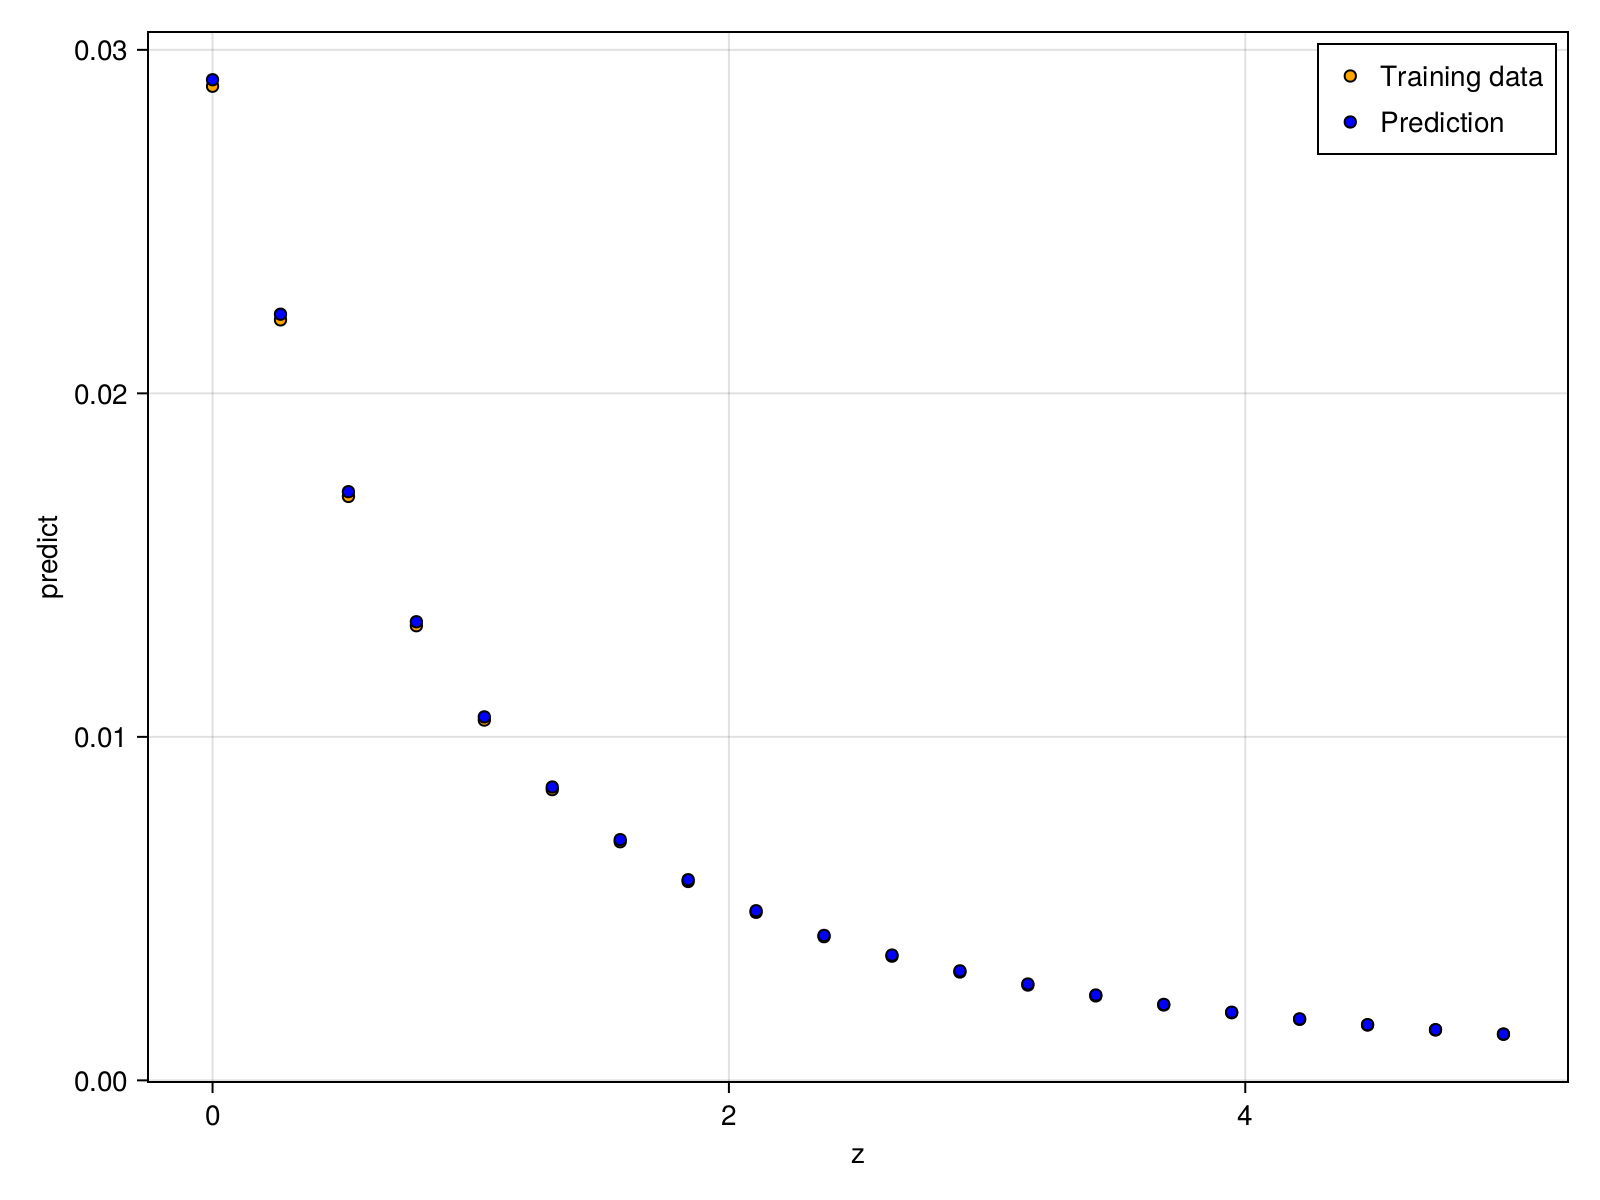

In [ ]:
zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h


fig = Figure(size = (800, 600))
ax = CairoMakie.Axis(fig[1, 1], xlabel="z", ylabel="predict")

s1 = scatter!(ax, zz, val_out[1:20,1]; markersize=8, color=:orange, strokecolor=:black, strokewidth=1)
s2 = scatter!(ax, zz, pred_val[1:20,1]; markersize=8, color=:blue, strokecolor=:black, strokewidth=1)

axislegend(ax, [s1, s2], ["Training data", "Prediction"])

return fig

In [ ]:
# preparo il plot delle differenze percentuali con il training dataset

diffk = zeros(Float64, nc*nz, nk)
diffz = zeros(Float64, nc*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk[:,i] = reshape(100*abs.(1 .- pred_train[start:stop,:] ./ output'[start:stop,:]), nc*nz, 1)
end
diffk = sort(diffk, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz[:,i] = reshape(100*abs.(1 .- pred_train[index,:] ./ output'[index,:]), nc*nk, 1)
end
diffz = sort(diffz, dims=1)


200000×20 Matrix{Float64}:
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
 ⋮                                   ⋱            

In [ ]:
# preparo il plot delle differenze percentuali con il validation dataset

diffk_v = zeros(Float64, ncv*nz, nk)
diffz_v = zeros(Float64, ncv*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk_v[:,i] = reshape(100*abs.(1 .- pred_val[start:stop,:] ./ val_out[start:stop,:]), ncv*nz, 1)
end
diffk_v = sort(diffk_v, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz_v[:,i] = reshape(100*abs.(1 .- pred_val[index,:] ./ val_out[index,:]), ncv*nk, 1)
end
diffz_v = sort(diffz_v, dims=1)

100000×20 Matrix{Float64}:
  7.55548e-6  7.01418e-6  8.27415e-6  6.46802e-8  …  9.29657e-6   1.65596e-5
  9.01604e-6  1.85385e-5  1.24485e-5  1.80917e-5     2.7692e-5    2.79806e-5
  2.07314e-5  2.03866e-5  1.69109e-5  2.5802e-5      7.1677e-5    2.84787e-5
  2.37884e-5  3.11506e-5  1.8489e-5   3.16625e-5     8.59413e-5   4.25315e-5
  3.56055e-5  5.03464e-5  2.0466e-5   3.68726e-5     9.55019e-5   7.02453e-5
  3.91547e-5  5.12115e-5  3.70731e-5  3.85589e-5  …  0.000106886  0.000143612
  4.27728e-5  5.28814e-5  4.9089e-5   3.96797e-5     0.000107665  0.000145174
  5.52142e-5  5.60146e-5  5.15117e-5  4.61806e-5     0.000184541  0.000186435
  6.41277e-5  5.95665e-5  5.45229e-5  5.55192e-5     0.00020033   0.000194593
  6.61474e-5  6.54366e-5  5.47531e-5  6.53446e-5     0.000221588  0.000267943
  7.25172e-5  6.92135e-5  7.41607e-5  6.74175e-5  …  0.000236426  0.000275383
  8.66182e-5  7.21143e-5  7.88903e-5  7.22977e-5     0.000260073  0.000335686
  8.76952e-5  7.71013e-5  7.96514e-5  7.86

In [ ]:
xax = [[3,4] [5,6]]
diffs = [[diffk,diffz] [diffk_v,diffz_v]]

xax

2×2 Matrix{Int64}:
 3  5
 4  6

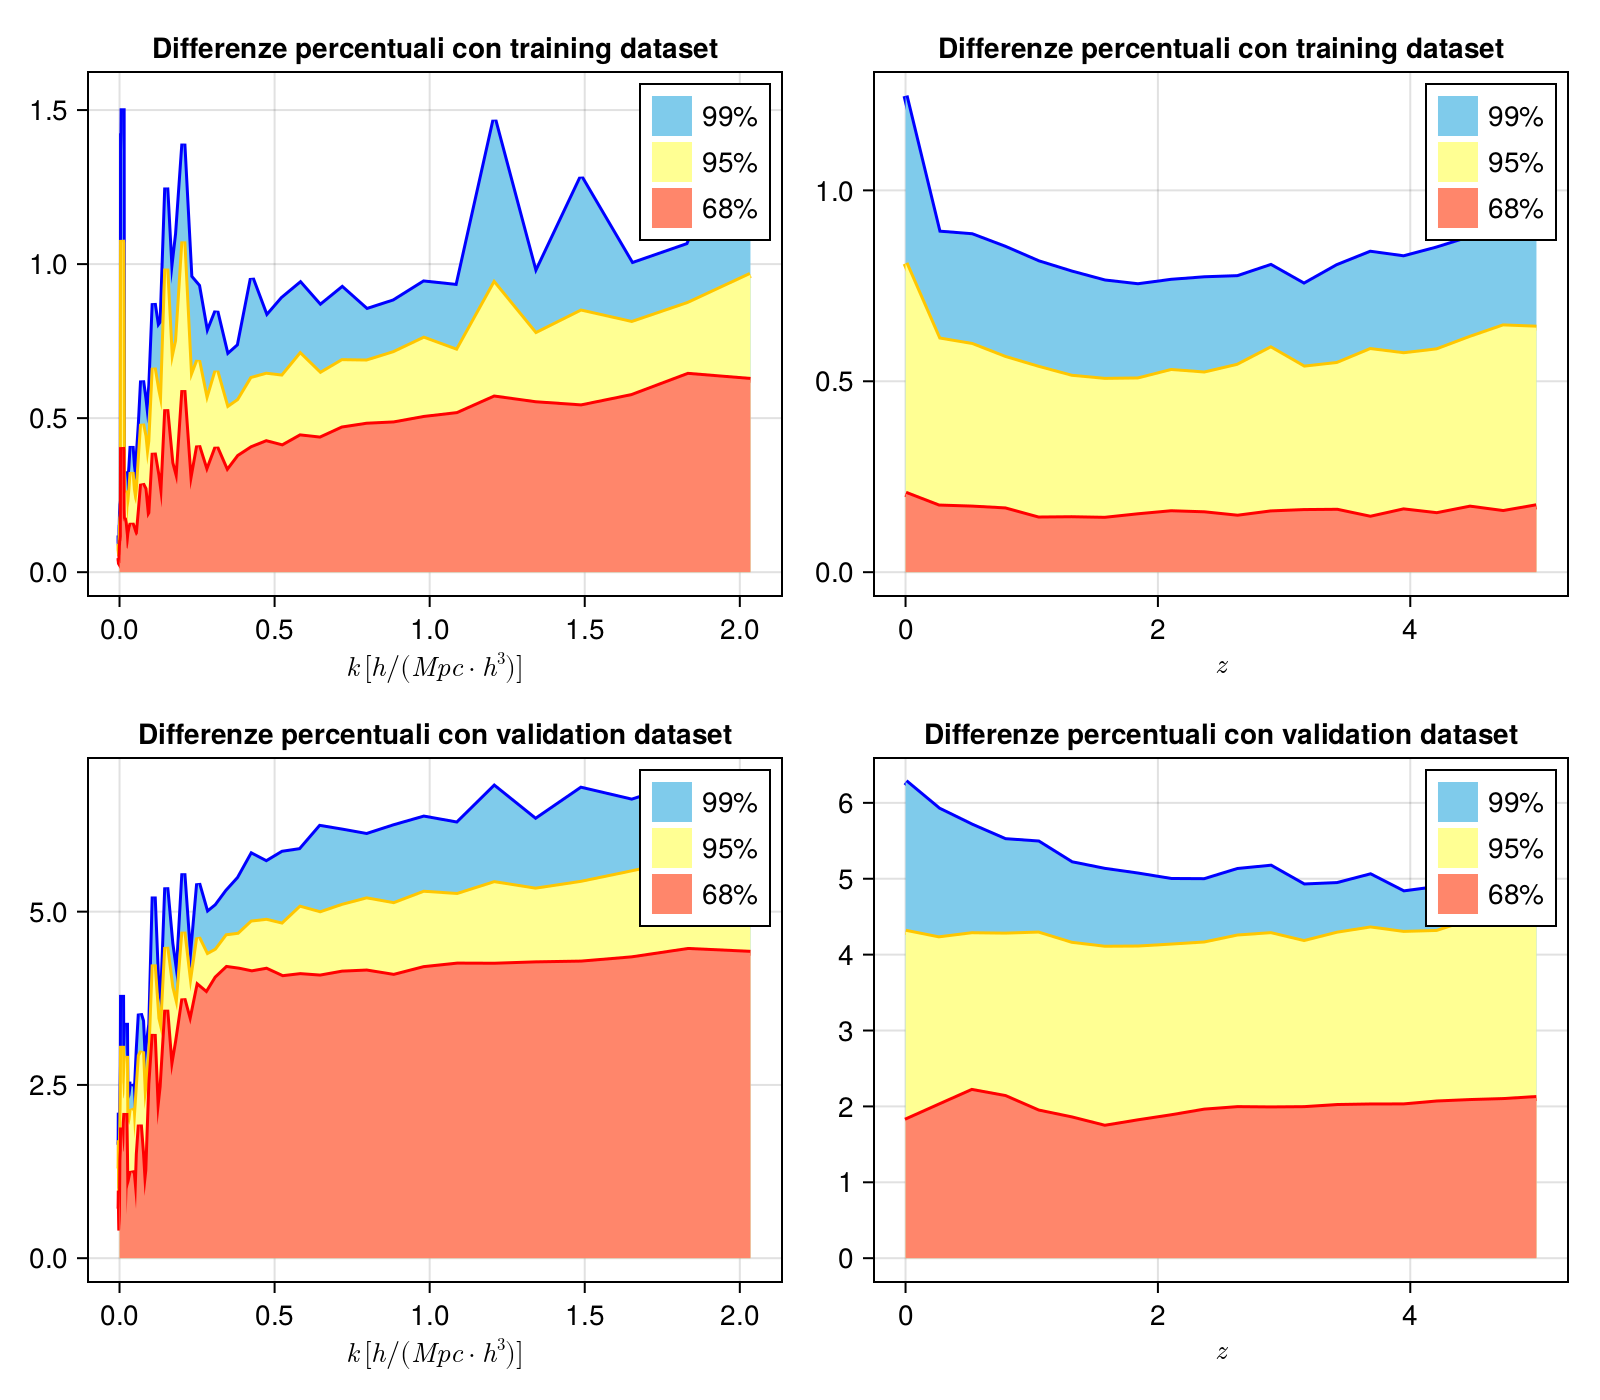

In [ ]:
fig = Figure(size = (800, 700))

xax = [[kk,kk] [zz,zz]]
diffs = [[diffk,diffk_v] [diffz,diffz_v]]


for i in 1:2
    for j in 1:2
        ax = CairoMakie.Axis(fig[i,j])
        
        ind99 = convert( Int, (size(diffs[i,j])[1]/100)*99 )
        l99 = lines!(ax, xax[i,j], diffs[i,j][ind99,:], linewidth=3, color=:blue)
        a99 = band!(ax, xax[i,j], 0, diffs[i,j][ind99,:], color="#7FCBEB")

        ind95 = convert( Int, (size(diffs[i,j])[1]/100)*95 )
        l95 = lines!(ax, xax[i,j], diffs[i,j][ind95,:], linewidth=3, color=:"#FFC600")
        a95 = band!(ax, xax[i,j], 0, diffs[i,j][ind95,:], color="#FFFF93")

        ind68 = convert( Int, (size(diffs[i,j])[1]/100)*68 )
        l68 = lines!(ax, xax[i,j], diffs[i,j][ind68,:], linewidth=3, color=:red)
        a68 = band!(ax, xax[i,j], 0, diffs[i,j][ind68,:], color="#FF866B")

        axislegend(ax, [a99, a95, a68], ["99%", "95%", "68%"])
        
        if i == 1
            ax.title = "Differenze percentuali con training dataset"
        else
            ax.title = "Differenze percentuali con validation dataset"
        end

        if j == 1
            ax.xlabel = L"k \, [h/(Mpc \cdot h^3)]"
        else
            ax.xlabel = L"z"
        end

    end
end

save("../plots/diff_nn.pdf", fig)
return fig


In [ ]:
jldsave("../models/nn.jld2"; tstate)